<a href="https://colab.research.google.com/github/archit1125/StockPrice/blob/main/btp_LSTM_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
!pip install pyspark
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



ValueError: ignored

## Single Feature Sentiment Analysis

In [ ]:
# data = [['2017-10-31T05:00:00.000-04:00', 0.092263,6158.76], ['2017-10-31T06:00:00.000-04:00', 0.103770,6105.90],['2017-10-31T07:00:00.000-04:00',0.111691,6094.36],['2017-10-31T08:00:00.000-04:00',0.082134,6125.13]] 
# for i in range(207):
#   data.append(data[0])
# # Create the pandas DataFrame 
# df = pd.DataFrame(data, columns =  ['DateTime','Sentiment_score','Price'])
# df.head()

,DateTime,Sentiment_score,Price
0,2017-10-31T05:00:00.000-04:00,0.092263,6158.76
1,2017-10-31T06:00:00.000-04:00,0.103770,6105.90
2,2017-10-31T07:00:00.000-04:00,0.111691,6094.36
3,2017-10-31T08:00:00.000-04:00,0.082134,6125.13
4,2017-10-31T05:00:00.000-04:00,0.092263,6158.76


In [124]:
df = pd.read_csv('mycsv.csv',header=None)
df=df.drop([0], axis=1)
df=df.drop([0], axis=0)
df.columns = ['DateTime','Sentiment_score','Price']
FullData=sql.createDataFrame(df)
FullData = FullData.withColumn("DateTime", FullData["DateTime"].cast(TimestampType()))
FullData = FullData.withColumn("Sentiment_score", FullData["Sentiment_score"].cast(DoubleType()))
FullData = FullData.withColumn("Price", FullData["Price"].cast(DoubleType()))

print(df)
df.head()

               DateTime        Sentiment_score               Price
1   2021-02-17 15:00:00   0.023831035203204072   275.3800048828125
2   2021-02-17 16:00:00   0.023831035203204072   275.3800048828125
3   2021-02-17 17:00:00   0.023831035203204072   275.3800048828125
4   2021-02-17 18:00:00  -0.018704572515988272    276.409912109375
5   2021-02-17 19:00:00  -0.018704572515988272    276.409912109375
..                  ...                    ...                 ...
92  2021-02-24 01:00:00   0.056063199788331984  330.93499755859375
93  2021-02-24 02:00:00    0.08972835863259301  330.93499755859375
94  2021-02-24 03:00:00    0.08972835863259301  330.93499755859375
95  2021-02-24 04:00:00    0.11491034411150834  330.93499755859375
96  2021-02-24 05:00:00    0.11491034411150834  330.93499755859375

[96 rows x 3 columns]


,DateTime,Sentiment_score,Price
1,2021-02-17 15:00:00,0.023831035203204072,275.3800048828125
2,2021-02-17 16:00:00,0.023831035203204072,275.3800048828125
3,2021-02-17 17:00:00,0.023831035203204072,275.3800048828125
4,2021-02-17 18:00:00,-0.018704572515988272,276.409912109375
5,2021-02-17 19:00:00,-0.018704572515988272,276.409912109375


In [ ]:
#df = df.drop(df.columns[1],axis = 1) Uncomment this for pure time series analysis, without sentiment score

Plotting the input variables

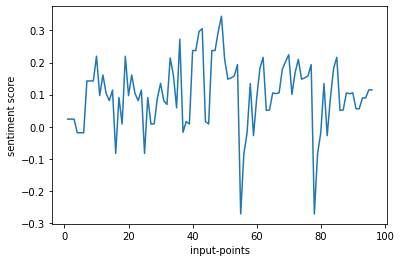

In [126]:
scores = df['Sentiment_score'].tolist()
x=range(1, 97, 1)
y=scores
y=list(map(float, y))
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('input-points') 
# naming the y axis 
plt.ylabel('sentiment score') 
 
plt.show() 
#print(values)
# # specify columns to plot
# groups = [1]
# i = 1
# # plot each column
# plt.figure()
# for group in groups:
# 	plt.subplot(len(groups), 1, i)
# 	plt.plot(values[:, group])
# 	plt.title(df.columns[group], y=1, loc='right')
# 	i += 1
# plt.show()



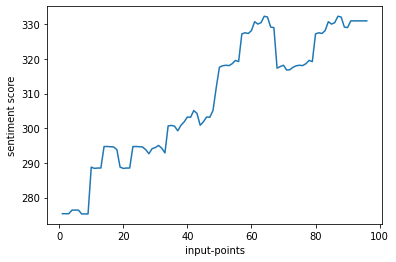

In [128]:
prices=df['Price'].tolist()
x=range(1, 97, 1)
y=prices
y=list(map(float, y))
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('input-points') 
# naming the y axis 
plt.ylabel('sentiment score') 
 
plt.show() 

Set index to datetime and change the order of columns

In [129]:
df.set_index('DateTime',inplace=True)  
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df


,Price,Sentiment_score
DateTime,,
2021-02-17 15:00:00,275.3800048828125,0.023831035203204072
2021-02-17 16:00:00,275.3800048828125,0.023831035203204072
2021-02-17 17:00:00,275.3800048828125,0.023831035203204072
2021-02-17 18:00:00,276.409912109375,-0.018704572515988272
2021-02-17 19:00:00,276.409912109375,-0.018704572515988272
...,...,...
2021-02-24 01:00:00,330.93499755859375,0.056063199788331984
2021-02-24 02:00:00,330.93499755859375,0.08972835863259301
2021-02-24 03:00:00,330.93499755859375,0.08972835863259301


In [130]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [131]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [132]:
n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [133]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.001141,0.479558,0.001141,0.479558,0.001141,0.479558,0.019224,0.410412
4,0.001141,0.479558,0.001141,0.479558,0.019224,0.410412,0.019224,0.410412
5,0.001141,0.479558,0.019224,0.410412,0.019224,0.410412,0.019224,0.410412
6,0.019224,0.410412,0.019224,0.410412,0.019224,0.410412,0.000000,0.672668
7,0.019224,0.410412,0.019224,0.410412,0.000000,0.672668,0.000000,0.672668


In [134]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
3,0.001141,0.479558,0.001141,0.479558,0.001141,0.479558,0.019224
4,0.001141,0.479558,0.001141,0.479558,0.019224,0.410412,0.019224
5,0.001141,0.479558,0.019224,0.410412,0.019224,0.410412,0.019224
6,0.019224,0.410412,0.019224,0.410412,0.019224,0.410412,0.000000
7,0.019224,0.410412,0.019224,0.410412,0.000000,0.672668,0.000000


In [143]:
values = reframed.values
n_train_hours = 85
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(85, 7)

In [144]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [145]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(85, 3, 1) (85,) (8, 3, 1) (8,)


In [146]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Epoch 1/20
22/22 - 2s - loss: 0.4780 - val_loss: 0.7648
Epoch 2/20
22/22 - 0s - loss: 0.3670 - val_loss: 0.6177
Epoch 3/20
22/22 - 0s - loss: 0.2615 - val_loss: 0.4729
Epoch 4/20
22/22 - 0s - loss: 0.1927 - val_loss: 0.3650
Epoch 5/20
22/22 - 0s - loss: 0.1767 - val_loss: 0.3006
Epoch 6/20
22/22 - 0s - loss: 0.1678 - val_loss: 0.2515
Epoch 7/20
22/22 - 0s - loss: 0.1615 - val_loss: 0.2130
Epoch 8/20
22/22 - 0s - loss: 0.1581 - val_loss: 0.1880
Epoch 9/20
22/22 - 0s - loss: 0.1548 - val_loss: 0.1701
Epoch 10/20
22/22 - 0s - loss: 0.1518 - val_loss: 0.1603
Epoch 11/20
22/22 - 0s - loss: 0.1489 - val_loss: 0.1575
Epoch 12/20
22/22 - 0s - loss: 0.1449 - val_loss: 0.1550
Epoch 13/20
22/22 - 0s - loss: 0.1411 - val_loss: 0.1547
Epoch 14/20
22/22 - 0s - loss: 0.1366 - val_loss: 0.1511
Epoch 15/20
22/22 - 0s - loss: 0.1315 - val_loss: 0.1419
Epoch 16/20
22/22 - 0s - loss: 0.1296 - val_loss: 0.1421
Epoch 17/20
22/22 - 0s - loss: 0.1261 - val_loss: 0.1404
Epoch 18/20
22/22 - 0s - loss: 0.1230 - 

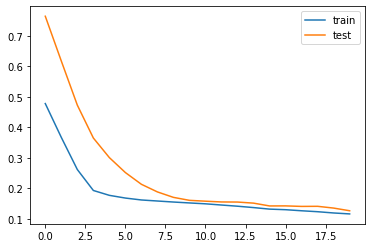

In [147]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [148]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.235


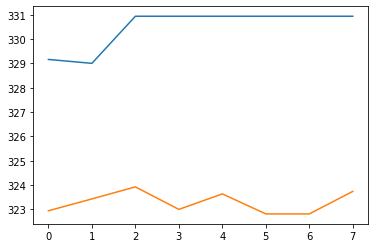

In [149]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [ ]:
inv_y = np.insert(inv_y,0,7000)

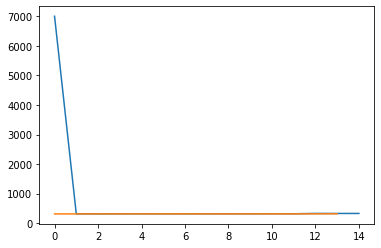

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()